<h1>Clustering</h1>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pprint
from sklearn.datasets import fetch_20newsgroups

<h2>Dataset</h2>

In [3]:
newsgroups = fetch_20newsgroups(subset='all')
print(newsgroups.target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [4]:
comp_tech_category = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
rec_category = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
eight_data = fetch_20newsgroups(subset='all', categories=comp_tech_category+rec_category, shuffle=True, random_state=42, remove=('headers','footers','quotes'))

In [5]:
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

<h2>Q1 - Building the TF-IDF matrix</h2>

In [6]:
# Tokenizer function
def tokenize(data):
    # Convert list data to string
    raw = "".join(doc for doc in data)
    # Split into words
    tokens = word_tokenize(raw)
    # Convert to lower case
    tokens = [w.lower() for w in tokens]
    # Remove punctuation and keep on alphanumeric tokens
    punctuations = list(string.punctuation)
    punctuations.append("''")
    words = [word for word in tokens if word not in punctuations]
    words = [word for word in words if word.isalpha()]
    # Filter out stopwords
    stop_words = text.ENGLISH_STOP_WORDS
    words = [w for w in words if not w in stop_words]
    # Stemming
    #stemmer = SnowballStemmer("english")
    #stemmed = [stemmer.stem(word) for word in words]
    return words  

In [7]:
# Question 1
vectorizer = CountVectorizer(analyzer="word", tokenizer=tokenize, min_df=3, stop_words="english")
counts = vectorizer.fit_transform(eight_data.data)
tfidf_transformer = TfidfTransformer(smooth_idf=False)
tfidf_vectors = tfidf_transformer.fit_transform(counts)

In [8]:
print("TFIDF Shape : ",tfidf_vectors.shape)

TFIDF Shape :  (7882, 13708)


<h2>Q2 - Applying K-means with k=2</h2>

In [9]:
from sklearn.cluster import KMeans

In [29]:
kmeans = KMeans(n_clusters=2).fit(tfidf_vectors)

In [30]:
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    

def performance_metrics(true_labels, preds, categories=["Computer Tech", "Recreational"], normalization=True):
    print("Homogeneity Score: ", metrics.homogeneity_score(true_labels, preds))
    print("Completeness Score: ", metrics.completeness_score(true_labels, preds))
    print("V-measure Score: ", metrics.v_measure_score(true_labels, preds))
    print("Adjusted Rand Score: ", metrics.adjusted_rand_score(true_labels, preds))
    print("Adjusted Mutual Info Score: ", metrics.adjusted_mutual_info_score(true_labels, preds))
    plot_confusion_matrix(metrics.confusion_matrix(true_labels, preds), categories, normalization)

In [31]:
true_labels = [int(i/4) for i in eight_data.target]

Homogeneity Score:  0.393025162072
Completeness Score:  0.436450697367
V-measure Score:  0.413601201571
Adjusted Rand Score:  0.390193673359
Adjusted Mutual Info Score:  0.392969591157
Normalized confusion matrix
[[ 0.63002818  0.36997182]
 [ 0.00879618  0.99120382]]


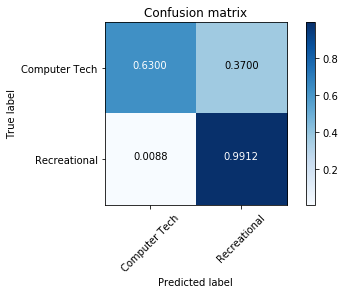

In [32]:
# Question 2 - a, b
performance_metrics(true_labels, kmeans.labels_)

<h2>Q3 - Preprocessing the data - Dimensionality Reduction</h2>

In [13]:
from sklearn.decomposition import TruncatedSVD

# Function that returns LSI representation
def getLSI(df, components):
    print("\nMin df: ", df)
    vectorizer = CountVectorizer(analyzer="word", tokenizer=tokenize, min_df=df, stop_words="english")
    counts = vectorizer.fit_transform(eight_data.data)
    tfidf_transformer = TfidfTransformer(smooth_idf=False)
    tfidf_vectors = tfidf_transformer.fit_transform(counts)
    svd = TruncatedSVD(n_components=components, n_iter=7, random_state=42)
    svd_data = svd.fit_transform(tfidf_vectors)
    return svd_data, svd

In [14]:
from sklearn.decomposition import NMF

# Function that returns NMF representation
def getNMF(df, components):
    print("\nMin df: ", df)
    vectorizer = CountVectorizer(analyzer="word", tokenizer=tokenize, min_df=df, stop_words="english")
    counts = vectorizer.fit_transform(eight_data.data)
    tfidf_transformer = TfidfTransformer(smooth_idf=False)
    tfidf_vectors = tfidf_transformer.fit_transform(counts)
    nmf = NMF(n_components=components, init='random', random_state=42)
    nmf_data = nmf.fit_transform(tfidf_vectors)
    return nmf_data, nmf

In [15]:
df = 3
svd_data, svd = getLSI(df, 1000)
print("LSI shape: ", svd_data.shape)   


Min df:  3
LSI shape:  (7882, 1000)


In [124]:
# Question 3 - a, i
def plot_variance(vec, rvals):
    var_ratio = vec.explained_variance_ratio_
    plt.figure()
    plt.plot(rvals, np.cumsum(var_ratio)*100, color="darkorange", lw=2)
    plt.xlabel("Top $r$ principle components")
    plt.ylabel("Percentage of variance retained")
    plt.show()

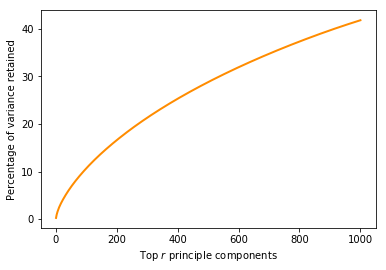

In [125]:
plot_variance(svd, range(1,1001,1))

In [18]:
rvals = [1,2,3,5,10,20,50,100,300]

<h3>Truncated SVD (LSI)</h3>

In [29]:
# Question 3 - a, ii
def plot_metrics_lsi(vec, rvals):
    h = []
    c = []
    v = []
    ar = []
    ami = []
    for i in rvals:
        #print("Number of components: ",i)
        kmeans = KMeans(n_clusters=2, n_init=30, max_iter=500).fit(vec[:,:i])
        true_labels = [int(i/4) for i in eight_data.target]
        preds = kmeans.labels_
        h.append(metrics.homogeneity_score(true_labels, preds))
        c.append(metrics.completeness_score(true_labels, preds))
        v.append(metrics.v_measure_score(true_labels, preds))
        ar.append(metrics.adjusted_rand_score(true_labels, preds))
        ami.append(metrics.adjusted_mutual_info_score(true_labels, preds))
        print("Number of principle components: ", i)
        performance_metrics(true_labels, preds, categories=["Computer Tech", "Recreational"], normalization=True)
    plt.figure()
    plt.plot(rvals, h, 'r', lw=6, label='Homogeneity')
    plt.plot(rvals, c, 'y', lw=4, label='Completeness')
    plt.plot(rvals, v, 'k', lw=2, label='V-measure score')
    plt.plot(rvals, ar, 'c', label='Rand score')
    plt.plot(rvals, ami, 'm', label='Mutual information score')
    plt.legend(fontsize='xx-small')
    plt.xlabel("Number of principle components")
    plt.ylabel("Purity metrics")
    plt.show()
    print("Best Homogeneity score: ", rvals[h.index(max(h))], max(h))
    print("Best Completeness score: ", rvals[c.index(max(c))], max(c))
    print("Best V-measure score: ", rvals[v.index(max(v))], max(v))
    print("Best Adjusted rand score: ", rvals[ar.index(max(ar))], max(ar))
    print("Best Adjusted mutual information score: ", rvals[ami.index(max(ami))], max(ami))

LSI reduced data
Number of principle components:  1
Homogeneity Score:  0.0788549706284
Completeness Score:  0.0813016076847
V-measure Score:  0.0800596010922
Adjusted Rand Score:  0.103734694887
Adjusted Mutual Info Score:  0.0787706386169
Normalized confusion matrix
[[ 0.44017422  0.55982578]
 [ 0.76049259  0.23950741]]


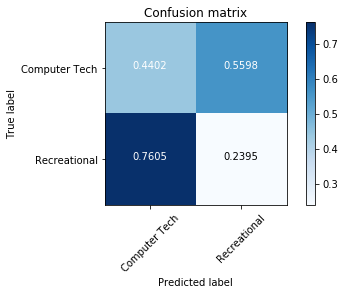

Number of principle components:  2
Homogeneity Score:  0.393187262952
Completeness Score:  0.433954055784
V-measure Score:  0.412566035757
Adjusted Rand Score:  0.396560726133
Adjusted Mutual Info Score:  0.393131707016
Normalized confusion matrix
[[ 0.36228542  0.63771458]
 [ 0.98869063  0.01130937]]


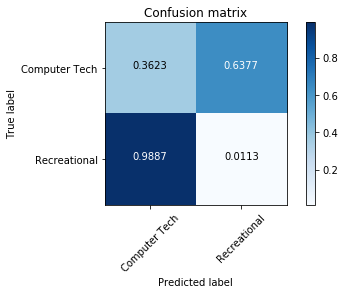

Number of principle components:  3
Homogeneity Score:  0.397043359368
Completeness Score:  0.437161053325
V-measure Score:  0.416137557069
Adjusted Rand Score:  0.401691521974
Adjusted Mutual Info Score:  0.396988156525
Normalized confusion matrix
[[ 0.35818601  0.64181399]
 [ 0.98869063  0.01130937]]


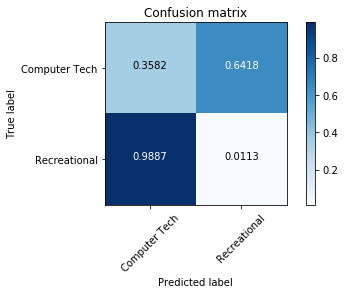

Number of principle components:  5
Homogeneity Score:  0.361105361038
Completeness Score:  0.414849687301
V-measure Score:  0.386116299984
Adjusted Rand Score:  0.338153232552
Adjusted Mutual Info Score:  0.361046866921
Normalized confusion matrix
[[ 0.58288496  0.41711504]
 [ 0.00527771  0.99472229]]


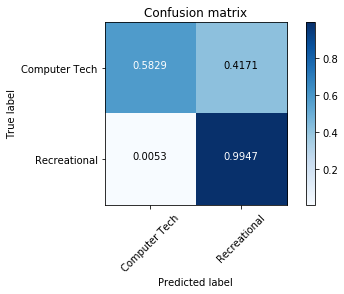

Number of principle components:  10
Homogeneity Score:  0.396202459769
Completeness Score:  0.440186064474
V-measure Score:  0.417037767606
Adjusted Rand Score:  0.391780656199
Adjusted Mutual Info Score:  0.396147179738
Normalized confusion matrix
[[ 0.6302844  0.3697156]
 [ 0.0077909  0.9922091]]


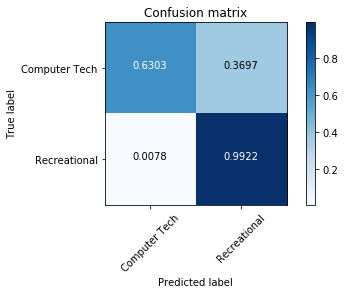

Number of principle components:  20
Homogeneity Score:  0.385307934902
Completeness Score:  0.431251466288
V-measure Score:  0.406987199356
Adjusted Rand Score:  0.37730215039
Adjusted Mutual Info Score:  0.385251657266
Normalized confusion matrix
[[ 0.38150141  0.61849859]
 [ 0.9922091   0.0077909 ]]


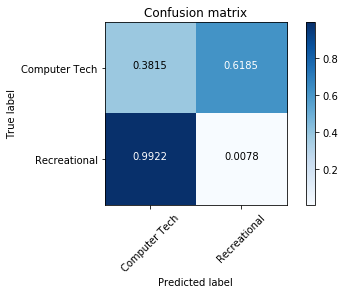

Number of principle components:  50
Homogeneity Score:  0.390809053398
Completeness Score:  0.436342831531
V-measure Score:  0.412322650905
Adjusted Rand Score:  0.383249383267
Adjusted Mutual Info Score:  0.390753279467
Normalized confusion matrix
[[ 0.37714579  0.62285421]
 [ 0.99271174  0.00728826]]


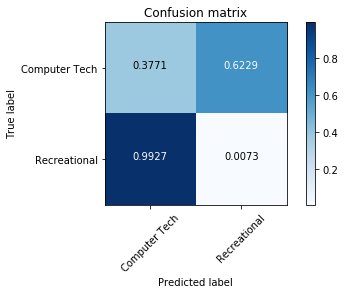

Number of principle components:  100
Homogeneity Score:  0.3905726028
Completeness Score:  0.436149304555
V-measure Score:  0.412104645042
Adjusted Rand Score:  0.382935212729
Adjusted Mutual Info Score:  0.390516807218
Normalized confusion matrix
[[ 0.377402    0.622598  ]
 [ 0.99271174  0.00728826]]


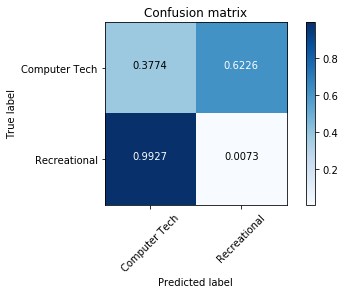

Number of principle components:  300
Homogeneity Score:  0.383107992456
Completeness Score:  0.430352058742
V-measure Score:  0.405358107091
Adjusted Rand Score:  0.372330054712
Adjusted Mutual Info Score:  0.383051513322
Normalized confusion matrix
[[ 0.61363054  0.38636946]
 [ 0.00703694  0.99296306]]


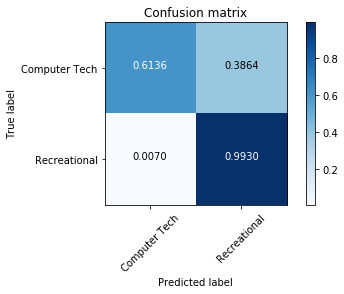

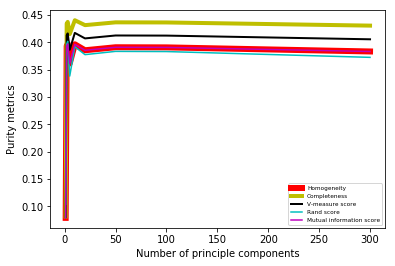

Best Homogeneity score:  3 0.397043359368
Best Completeness score:  10 0.440186064474
Best V-measure score:  10 0.417037767606
Best Adjusted rand score:  3 0.401691521974
Best Adjusted mutual information score:  3 0.396988156525


In [31]:
print("LSI reduced data")
plot_metrics_lsi(svd_data, rvals)

<h3>NMF</h3>

In [32]:
# Question 3 - a, ii
def plot_metrics_nmf(rvals):
    h = []
    c = []
    v = []
    ar = []
    ami = []
    for i in rvals:
        #print("Number of components: ",i)
        nmf_data, nmf = getNMF(df, i)
        print("NMF shape: ", nmf_data.shape) 
        kmeans = KMeans(n_clusters=2, n_init=30, max_iter=500).fit(nmf_data)
        true_labels = [int(i/4) for i in eight_data.target]
        preds = kmeans.labels_
        h.append(metrics.homogeneity_score(true_labels, preds))
        c.append(metrics.completeness_score(true_labels, preds))
        v.append(metrics.v_measure_score(true_labels, preds))
        ar.append(metrics.adjusted_rand_score(true_labels, preds))
        ami.append(metrics.adjusted_mutual_info_score(true_labels, preds))
        print("Number of principle components: ", i)
        performance_metrics(true_labels, preds, categories=["Computer Tech", "Recreational"], normalization=True)
    plt.figure()
    plt.plot(rvals, h, 'r', lw=6, label='Homogeneity')
    plt.plot(rvals, c, 'y', lw=4, label='Completeness')
    plt.plot(rvals, v, 'k', lw=2, label='V-measure score')
    plt.plot(rvals, ar, 'c', label='Rand score')
    plt.plot(rvals, ami, 'm', label='Mutual information score')
    plt.legend(fontsize='xx-small')
    plt.xlabel("Number of principle components")
    plt.ylabel("Purity metrics")
    plt.show()
    print("Best Homogeneity score: ", rvals[h.index(max(h))], max(h))
    print("Best Completeness score: ", rvals[c.index(max(c))], max(c))
    print("Best V-measure score: ", rvals[v.index(max(v))], max(v))
    print("Best Adjusted rand score: ", rvals[ar.index(max(ar))], max(ar))
    print("Best Adjusted mutual information score: ", rvals[ami.index(max(ami))], max(ami))

NMF reduced data

Min df:  3
NMF shape:  (7882, 1)
Number of principle components:  1
Homogeneity Score:  0.0788549706284
Completeness Score:  0.0813016076847
V-measure Score:  0.0800596010922
Adjusted Rand Score:  0.103734694887
Adjusted Mutual Info Score:  0.0787706386169
Normalized confusion matrix
[[ 0.44017422  0.55982578]
 [ 0.76049259  0.23950741]]


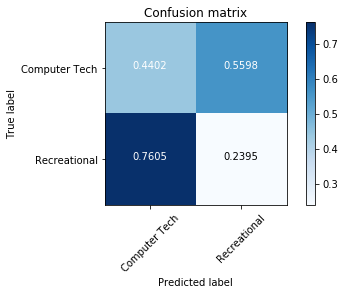


Min df:  3
NMF shape:  (7882, 2)
Number of principle components:  2
Homogeneity Score:  0.367637977063
Completeness Score:  0.381252362725
V-measure Score:  0.374321419134
Adjusted Rand Score:  0.424855977048
Adjusted Mutual Info Score:  0.367580083383
Normalized confusion matrix
[[ 0.05892903  0.94107097]
 [ 0.71299321  0.28700679]]


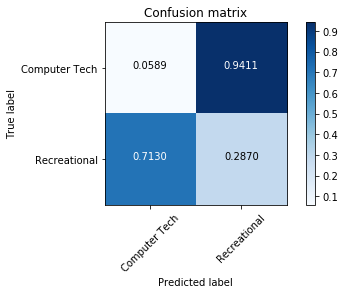


Min df:  3
NMF shape:  (7882, 3)
Number of principle components:  3
Homogeneity Score:  0.0429874533488
Completeness Score:  0.145234449968
V-measure Score:  0.0663393476808
Adjusted Rand Score:  0.0112590094255
Adjusted Mutual Info Score:  0.0428997482956
Normalized confusion matrix
[[ 0.10171663  0.89828337]
 [ 0.00376979  0.99623021]]


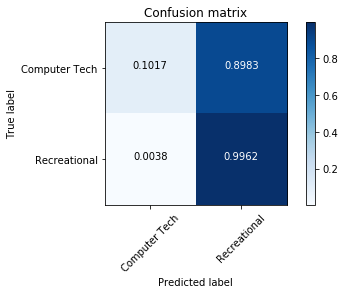


Min df:  3
NMF shape:  (7882, 5)
Number of principle components:  5
Homogeneity Score:  0.460382375837
Completeness Score:  0.472950295865
V-measure Score:  0.466581718319
Adjusted Rand Score:  0.533979385572
Adjusted Mutual Info Score:  0.460332973215
Normalized confusion matrix
[[ 0.77222649  0.22777351]
 [ 0.04322694  0.95677306]]


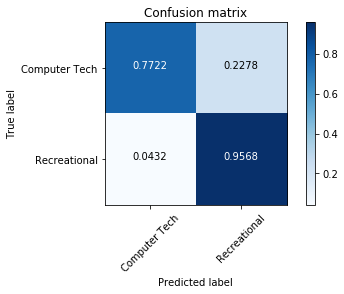


Min df:  3
NMF shape:  (7882, 10)
Number of principle components:  10
Homogeneity Score:  0.03745251184
Completeness Score:  0.138446407117
V-measure Score:  0.0589561974855
Adjusted Rand Score:  0.00895611599248
Adjusted Mutual Info Score:  0.0373642857115
Normalized confusion matrix
[[ 0.91006918  0.08993082]
 [ 0.99648153  0.00351847]]


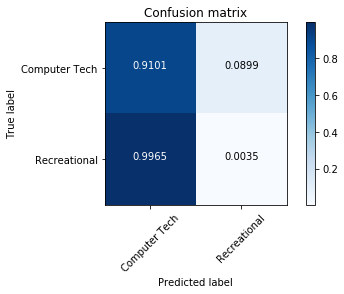


Min df:  3
NMF shape:  (7882, 20)
Number of principle components:  20
Homogeneity Score:  0.0295022708279
Completeness Score:  0.0356850415453
V-measure Score:  0.0323004499448
Adjusted Rand Score:  0.0292199970494
Adjusted Mutual Info Score:  0.0294134147311
Normalized confusion matrix
[[ 0.8288496   0.1711504 ]
 [ 0.65292787  0.34707213]]


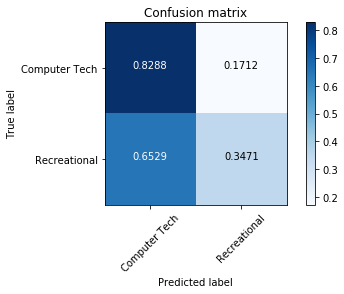


Min df:  3
NMF shape:  (7882, 50)
Number of principle components:  50
Homogeneity Score:  0.0063919348274
Completeness Score:  0.0129446971407
V-measure Score:  0.00855802195753
Adjusted Rand Score:  0.00244395039402
Adjusted Mutual Info Score:  0.00630093282733
Normalized confusion matrix
[[ 0.92134256  0.07865744]
 [ 0.86328223  0.13671777]]


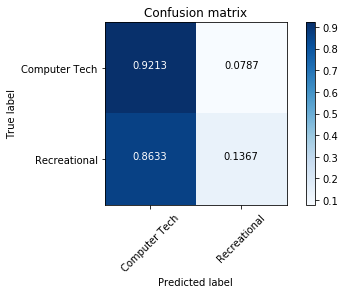


Min df:  3
NMF shape:  (7882, 100)
Number of principle components:  100
Homogeneity Score:  1.71220012934e-05
Completeness Score:  2.9262638396e-05
V-measure Score:  2.1603484939e-05
Adjusted Rand Score:  -9.67224860283e-05
Adjusted Mutual Info Score:  -7.44516621716e-05
Normalized confusion matrix
[[ 0.13861132  0.86138868]
 [ 0.14199548  0.85800452]]


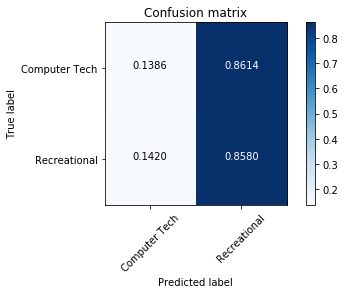


Min df:  3
NMF shape:  (7882, 300)
Number of principle components:  300
Homogeneity Score:  0.00188528186238
Completeness Score:  0.00618253583535
V-measure Score:  0.00288946109359
Adjusted Rand Score:  0.000906159997724
Adjusted Mutual Info Score:  0.00179381442423
Normalized confusion matrix
[[ 0.933897    0.066103  ]
 [ 0.95702438  0.04297562]]


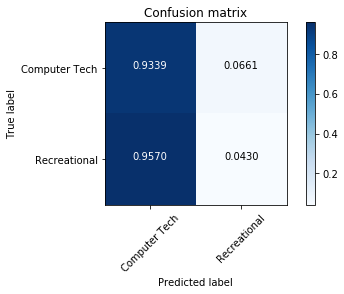

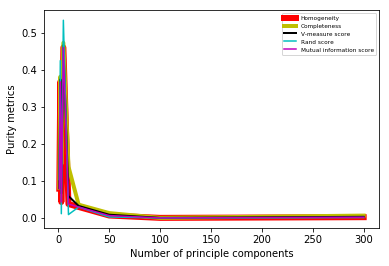

Best Homogeneity score:  5 0.460382375837
Best Completeness score:  5 0.472950295865
Best V-measure score:  5 0.466581718319
Best Adjusted rand score:  5 0.533979385572
Best Adjusted mutual information score:  5 0.460332973215


In [33]:
print("NMF reduced data")
plot_metrics_nmf(rvals)

<h2>Q4 - Visualization</h2>

In [126]:
df = 3
import matplotlib.pyplot as plt
svd_data, svd = getLSI(df,3) #Best r = 3


Min df:  3


In [127]:
def plot_clusters(data):
    reduced_svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42) #reduce to 2 dimensions
    svd_data_reduced = reduced_svd.fit_transform(data)
    preds = KMeans(n_clusters=2).fit_predict(svd_data_reduced)
    plt.scatter(svd_data_reduced[:, 0], svd_data_reduced[:, 1], c=preds, marker = '.')
    plt.show()

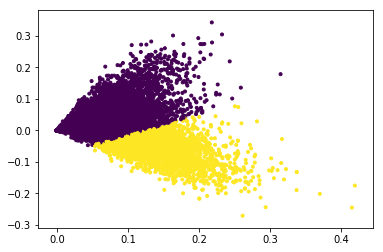

In [133]:
plot_clusters(svd_data)

In [134]:
nmf_data, nmf = getNMF(df,5) #Best r = 5


Min df:  3


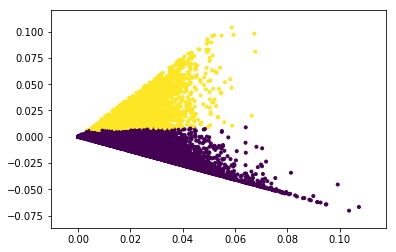

In [144]:
plot_clusters(nmf_data)

In [138]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss_data = ss.fit_transform(svd_data)

Homogeneity Score:  0.319204873
Completeness Score:  0.359901656876
V-measure Score:  0.338333847847
Adjusted Rand Score:  0.3238436151
Adjusted Mutual Info Score:  0.319142543163
Normalized confusion matrix
[[ 0.59005893  0.40994107]
 [ 0.0246293   0.9753707 ]]


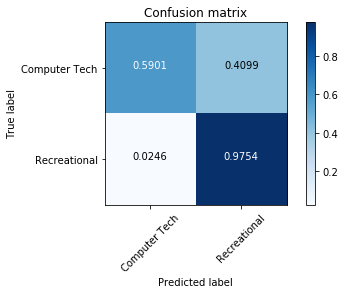

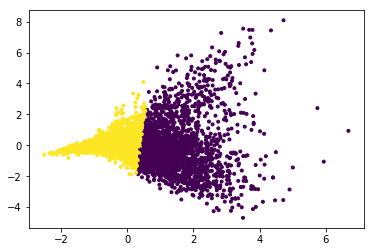

In [143]:
kmeans = KMeans(n_clusters=2).fit(ss_data)
performance_metrics(true_labels,kmeans.labels_)
plot_clusters(ss_data)

In [145]:
ss_data_nmf = ss.fit_transform(nmf_data)

Homogeneity Score:  0.426785706124
Completeness Score:  0.446684961736
V-measure Score:  0.436508663254
Adjusted Rand Score:  0.480496162999
Adjusted Mutual Info Score:  0.426733227327
Normalized confusion matrix
[[ 0.72508327  0.27491673]
 [ 0.03417944  0.96582056]]


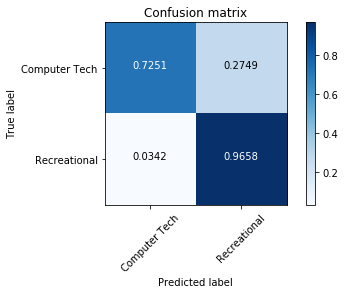

In [148]:
kmeans = KMeans(n_clusters=2).fit(ss_data_nmf)
performance_metrics(true_labels,kmeans.labels_)

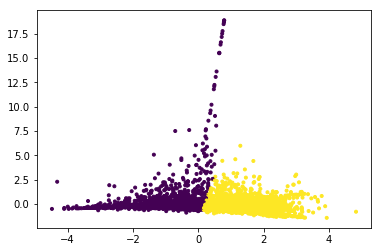

In [149]:
plot_clusters(ss_data_nmf)

In [150]:
nmf_data = nmf_data + 0.001

In [151]:
nmf_data_log = np.log(nmf_data)

Homogeneity Score:  0.476228965365
Completeness Score:  0.478404070456
V-measure Score:  0.477314039952
Adjusted Rand Score:  0.578642507072
Adjusted Mutual Info Score:  0.476181013902
Normalized confusion matrix
[[ 0.84370997  0.15629003]
 [ 0.08368937  0.91631063]]


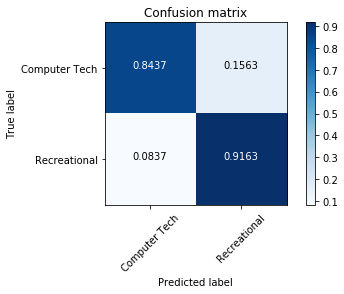

In [153]:
kmeans = KMeans(n_clusters=2).fit(nmf_data_log)
performance_metrics(true_labels,kmeans.labels_)

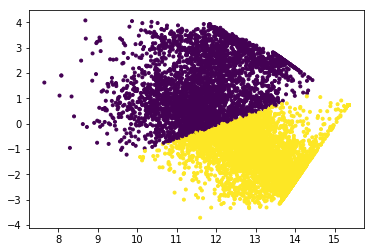

In [154]:
plot_clusters(nmf_data_log)

In [155]:
#normalize then log
ss2 = StandardScaler(with_mean = False)
ss_nmf_data = ss2.fit_transform(nmf_data)

In [156]:
ss_nmf_data_new = ss_nmf_data + 0.001
ss_data_nmf_log = np.log(ss_nmf_data_new)

Homogeneity Score:  0.476905415055
Completeness Score:  0.479055475383
V-measure Score:  0.477978027359
Adjusted Rand Score:  0.57941497054
Adjusted Mutual Info Score:  0.476857525523
Normalized confusion matrix
[[ 0.84422239  0.15577761]
 [ 0.08368937  0.91631063]]


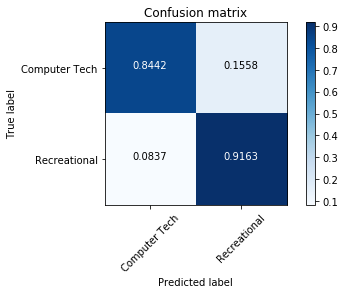

In [158]:
kmeans = KMeans(n_clusters=2).fit(ss_data_nmf_log)
performance_metrics(true_labels,kmeans.labels_)

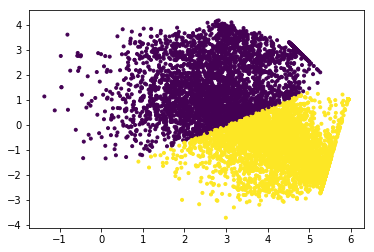

In [159]:
plot_clusters(ss_data_nmf_log)

In [160]:
#log then normalization
nmf_data_log_ss = ss.fit_transform(nmf_data_log)

Homogeneity Score:  0.471229106372
Completeness Score:  0.473164044519
V-measure Score:  0.472194593227
Adjusted Rand Score:  0.574018528316
Adjusted Mutual Info Score:  0.471180697178
Normalized confusion matrix
[[ 0.84422239  0.15577761]
 [ 0.08720784  0.91279216]]


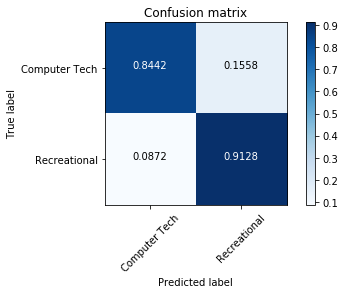

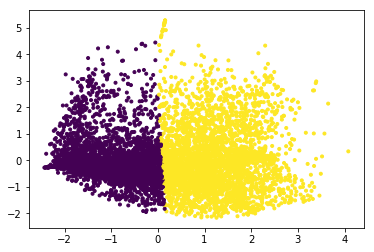

In [196]:
kmeans = KMeans(n_clusters=2).fit(nmf_data_log_ss)
performance_metrics(true_labels,kmeans.labels_)
plot_clusters(nmf_data_log_ss)

<h2>Q5 - Expand Dataset into 20 categories</h2>

In [182]:
all_data = fetch_20newsgroups(subset='all', categories=newsgroups.target_names, shuffle=True, random_state=42, remove=('headers','footers','quotes'))

In [184]:
vectorizer = CountVectorizer(analyzer="word", tokenizer=tokenize, min_df=3, stop_words="english")
counts = vectorizer.fit_transform(all_data.data)
tfidf_transformer = TfidfTransformer(smooth_idf=False)
tfidf_vectors = tfidf_transformer.fit_transform(counts)
svd = TruncatedSVD(n_components=1000, n_iter=7, random_state=42)
svd_data = svd.fit_transform(tfidf_vectors)

In [174]:
rvals2 = [3, 5, 10, 30, 100]

In [175]:
def confusion_matrix_20(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [176]:
def clusters_20(data):
    reduced_svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42) #reduce to 2 dimensions
    svd_data_reduced = reduced_svd.fit_transform(data)
    preds = KMeans(n_clusters=20).fit(svd_data_reduced)
    plt.scatter(svd_data_reduced[:, 0], svd_data_reduced[:, 1], c=preds.labels_.astype(float), marker = '.')
    plt.show()

In [177]:
def metrics_20(true_labels, preds):
    print("Homogeneity Score: ", metrics.homogeneity_score(true_labels, preds))
    print("Completeness Score: ", metrics.completeness_score(true_labels, preds))
    print("V-measure Score: ", metrics.v_measure_score(true_labels, preds))
    print("Adjusted Rand Score: ", metrics.adjusted_rand_score(true_labels, preds))
    print("Adjusted Mutual Info Score: ", metrics.adjusted_mutual_info_score(true_labels, preds))
   

In [192]:
def plot_metrics_lsi_20(vec, rvals):
    for i in rvals:
        print("\nNumber of principle components: ", i)
        print("\nNo transformation")
        kmeans = KMeans(n_clusters=20, n_init=30, max_iter=500).fit(vec[:,:i])
        true_labels = [i for i in all_data.target]
        preds = kmeans.labels_
        cm = metrics.confusion_matrix(true_labels, preds)
        confusion_matrix_20(cm, all_data.target_names)
        clusters_20(vec[:,:i])
        metrics_20(true_labels, preds)
        print("\nNormalizing features for unit variance")
        ss = StandardScaler()
        ss_data = ss.fit_transform(vec[:,:i])
        kmeans = KMeans(n_clusters=20).fit(ss_data)
        preds = kmeans.labels_
        cm = metrics.confusion_matrix(true_labels, preds)
        confusion_matrix_20(cm, all_data.target_names)
        clusters_20(ss_data)
        metrics_20(true_labels,kmeans.labels_)


Number of principle components:  3

No transformation


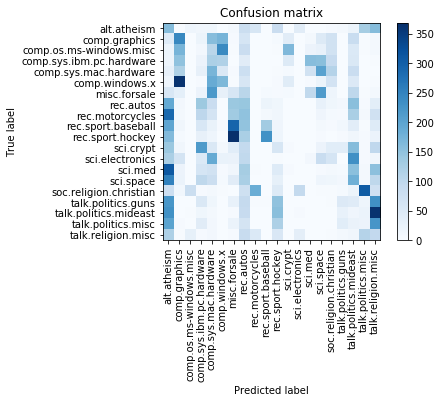

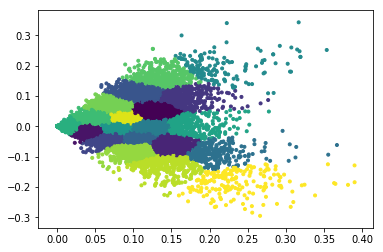

Homogeneity Score:  0.220360422618
Completeness Score:  0.241178746393
V-measure Score:  0.230300065736
Adjusted Rand Score:  0.0705946279434
Adjusted Mutual Info Score:  0.217833865919

Normalizing features for unit variance


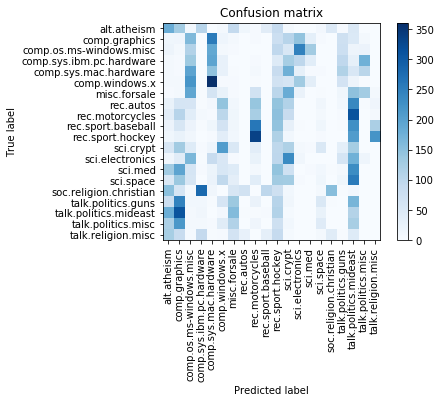

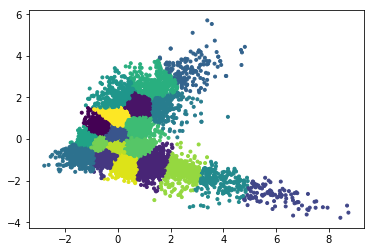

Homogeneity Score:  0.213658378792
Completeness Score:  0.234017907211
V-measure Score:  0.223375185268
Adjusted Rand Score:  0.0668379094431
Adjusted Mutual Info Score:  0.211108525208

Number of principle components:  5

No transformation


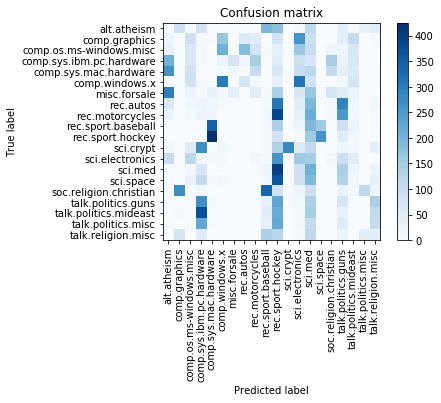

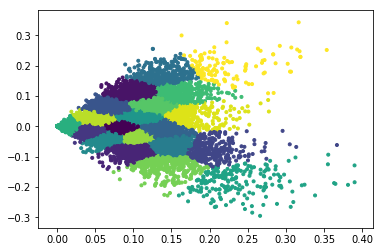

Homogeneity Score:  0.258135356163
Completeness Score:  0.289361883092
V-measure Score:  0.272858116522
Adjusted Rand Score:  0.0814232567645
Adjusted Mutual Info Score:  0.255731911286

Normalizing features for unit variance


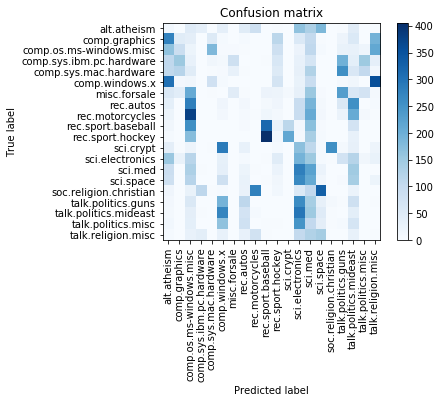

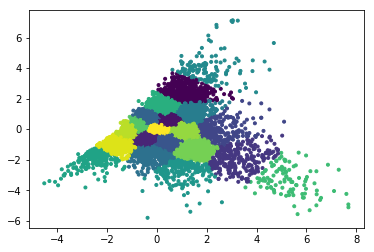

Homogeneity Score:  0.254280484293
Completeness Score:  0.280878982933
V-measure Score:  0.266918734254
Adjusted Rand Score:  0.0833290103587
Adjusted Mutual Info Score:  0.251865307358

Number of principle components:  10

No transformation


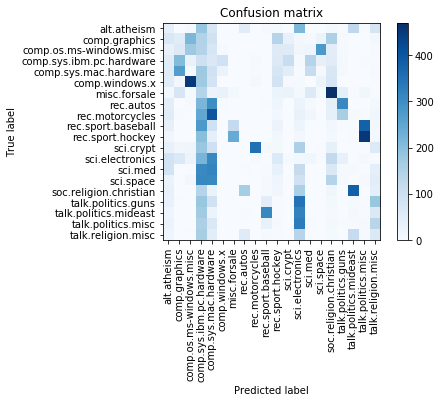

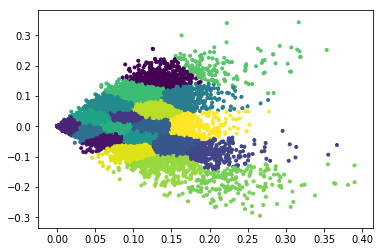

Homogeneity Score:  0.27356466346
Completeness Score:  0.308296185497
V-measure Score:  0.289893854803
Adjusted Rand Score:  0.0908306692028
Adjusted Mutual Info Score:  0.271212648378

Normalizing features for unit variance


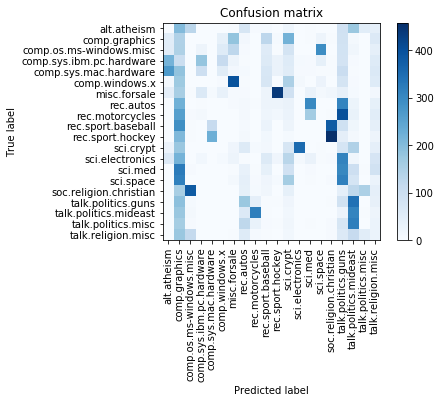

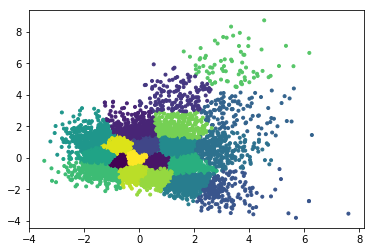

Homogeneity Score:  0.274093018233
Completeness Score:  0.307493454302
V-measure Score:  0.289834144901
Adjusted Rand Score:  0.0879474485617
Adjusted Mutual Info Score:  0.271744590828

Number of principle components:  30

No transformation


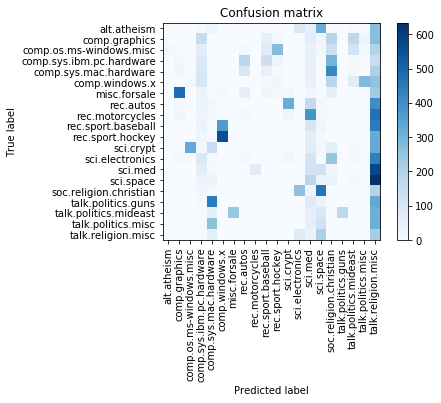

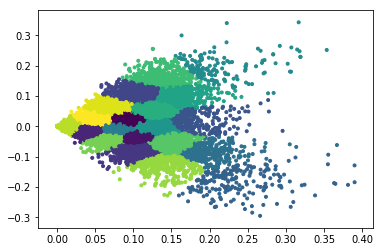

Homogeneity Score:  0.282125429908
Completeness Score:  0.356963525838
V-measure Score:  0.315162661733
Adjusted Rand Score:  0.0722383644191
Adjusted Mutual Info Score:  0.279774172179

Normalizing features for unit variance


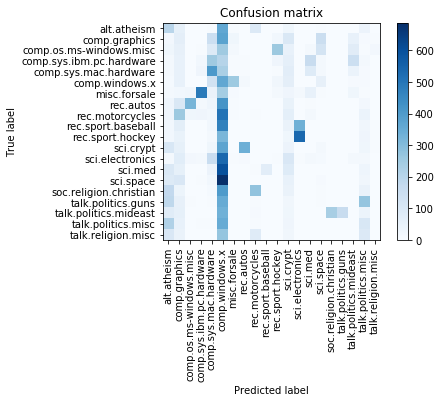

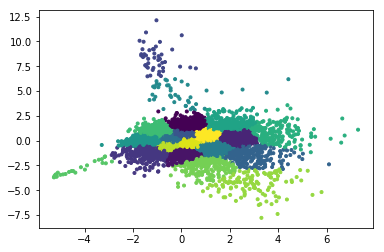

Homogeneity Score:  0.231403748794
Completeness Score:  0.305825774635
V-measure Score:  0.263459946418
Adjusted Rand Score:  0.0463806139314
Adjusted Mutual Info Score:  0.228885807275

Number of principle components:  100

No transformation


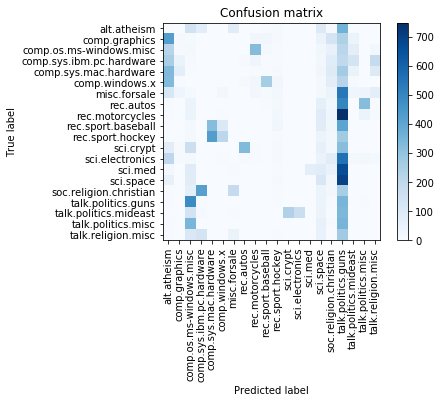

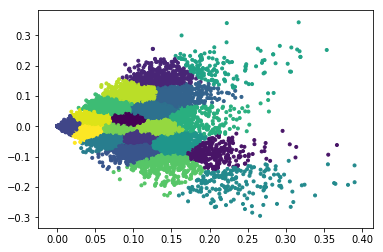

Homogeneity Score:  0.25571238098
Completeness Score:  0.345188983846
V-measure Score:  0.293788971416
Adjusted Rand Score:  0.054241162293
Adjusted Mutual Info Score:  0.253287396966

Normalizing features for unit variance


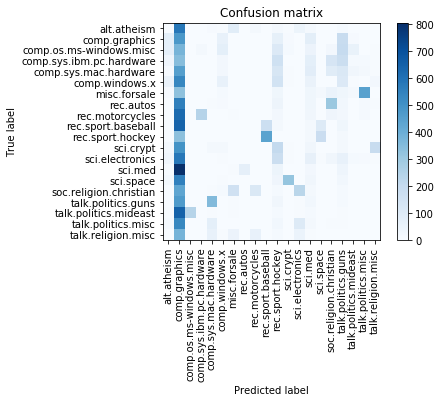

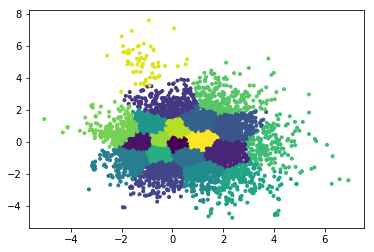

Homogeneity Score:  0.212542138768
Completeness Score:  0.325477844586
V-measure Score:  0.257156831903
Adjusted Rand Score:  0.0245527502945
Adjusted Mutual Info Score:  0.209974330869


In [193]:
plot_metrics_lsi_20(svd_data, rvals2)

In [213]:
def getNMF20(df, components):
    print("\nMin df: ", df)
    vectorizer = CountVectorizer(analyzer="word", tokenizer=tokenize, min_df=df, stop_words="english")
    counts = vectorizer.fit_transform(all_data.data)
    tfidf_transformer = TfidfTransformer(smooth_idf=False)
    tfidf_vectors = tfidf_transformer.fit_transform(counts)
    nmf = NMF(n_components=components, init='random', random_state=42)
    nmf_data = nmf.fit_transform(tfidf_vectors)
    return nmf_data, nmf

In [218]:
def plot_metrics_nmf_20(rvals):
    for i in rvals:
        nmf_data, nmf = getNMF20(3, i)
        print("Number of principle components: ", i)
        print("\nNo transformation")
        kmeans = KMeans(n_clusters=20, n_init=30, max_iter=500).fit(nmf_data)
        true_labels = [i for i in all_data.target]
        preds = kmeans.labels_
        cm = metrics.confusion_matrix(true_labels, preds)
        confusion_matrix_20(cm, all_data.target_names)
        clusters_20(nmf_data)
        metrics_20(true_labels, preds)
        print("\nNormalize then log")
        ss2 = StandardScaler(with_mean = False)
        ss_nmf_data = ss2.fit_transform(nmf_data)
        ss_nmf_data_new = ss_nmf_data + 0.001
        ss_data_nmf_log = np.log(ss_nmf_data_new)
        kmeans = KMeans(n_clusters=20, n_init=30, max_iter=500).fit(ss_data_nmf_log)
        preds = kmeans.labels_
        cm = metrics.confusion_matrix(true_labels, preds)
        confusion_matrix_20(cm, all_data.target_names)
        clusters_20(nmf_data)
        metrics_20(true_labels, preds)
        print("\nLog then normalize")
        ss = StandardScaler()
        nmf_data_new = nmf_data + 0.001
        nmf_data_log = np.log(nmf_data_new)
        nmf_data_log_ss = ss.fit_transform(nmf_data_log)
        kmeans = KMeans(n_clusters=20, n_init=30, max_iter=500).fit(nmf_data_log_ss)
        preds = kmeans.labels_
        cm = metrics.confusion_matrix(true_labels, preds)
        confusion_matrix_20(cm, all_data.target_names)
        clusters_20(nmf_data)
        metrics_20(true_labels, preds)


Min df:  3
Number of principle components:  3

No transformation


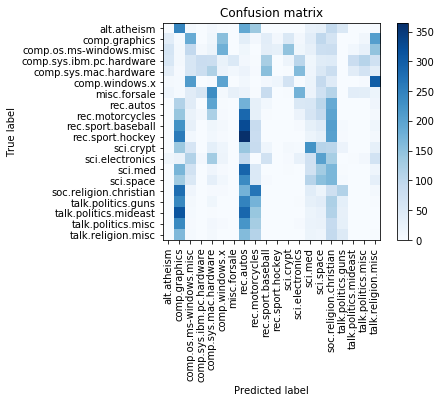

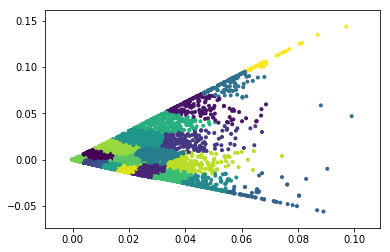

Homogeneity Score:  0.180587289922
Completeness Score:  0.208185699022
V-measure Score:  0.193406909719
Adjusted Rand Score:  0.0513627541154
Adjusted Mutual Info Score:  0.177913848992

Normalize then log


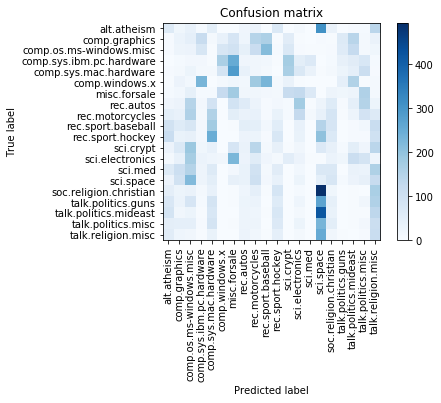

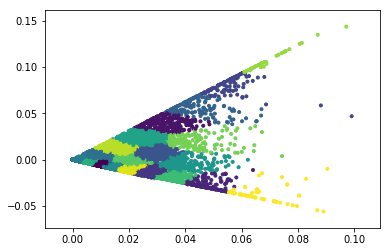

Homogeneity Score:  0.189230474266
Completeness Score:  0.198447485787
V-measure Score:  0.193729413182
Adjusted Rand Score:  0.0701362625671
Adjusted Mutual Info Score:  0.186610003413

Log then normalize


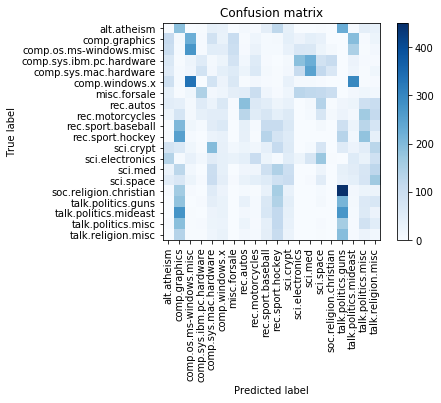

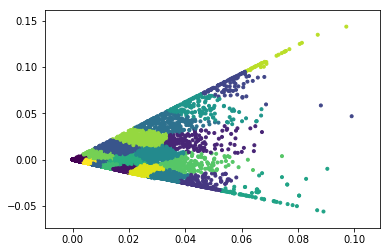

Homogeneity Score:  0.199713520221
Completeness Score:  0.205981542211
V-measure Score:  0.202799110489
Adjusted Rand Score:  0.072359478888
Adjusted Mutual Info Score:  0.197129049758

Min df:  3
Number of principle components:  5

No transformation


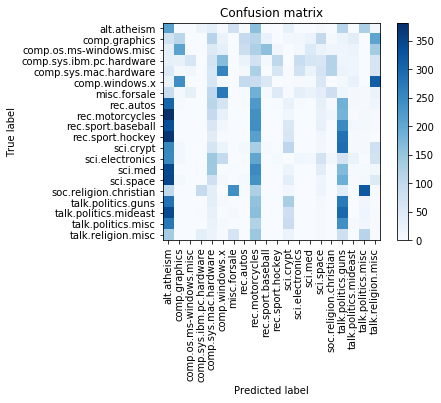

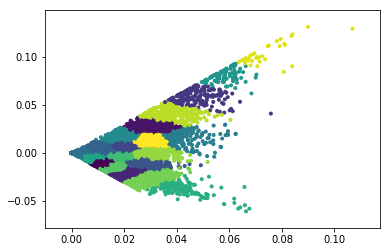

Homogeneity Score:  0.183374019224
Completeness Score:  0.223114990031
V-measure Score:  0.201301838621
Adjusted Rand Score:  0.0456582692538
Adjusted Mutual Info Score:  0.180718590008

Normalize then log


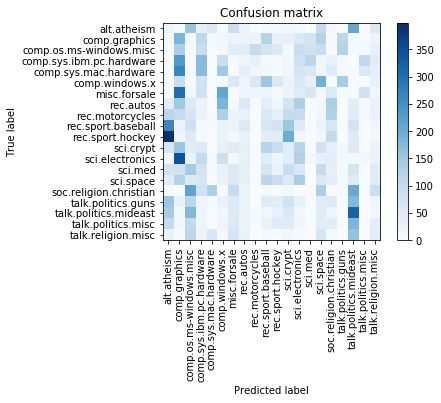

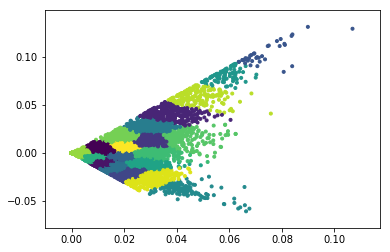

Homogeneity Score:  0.163357806598
Completeness Score:  0.17143217705
V-measure Score:  0.167297624129
Adjusted Rand Score:  0.0577895816788
Adjusted Mutual Info Score:  0.160653460777

Log then normalize


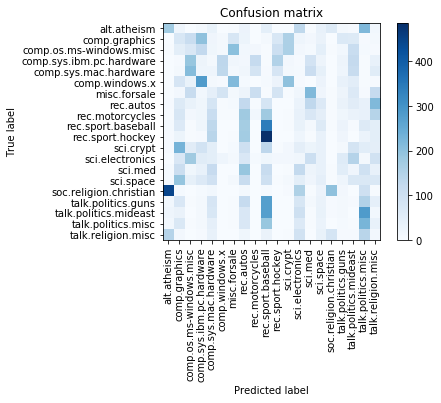

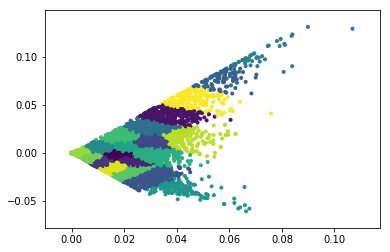

Homogeneity Score:  0.223980475249
Completeness Score:  0.232724413019
V-measure Score:  0.228268739701
Adjusted Rand Score:  0.0837486720759
Adjusted Mutual Info Score:  0.221473842479

Min df:  3
Number of principle components:  10

No transformation


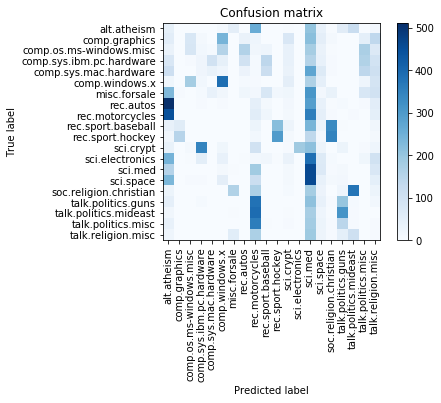

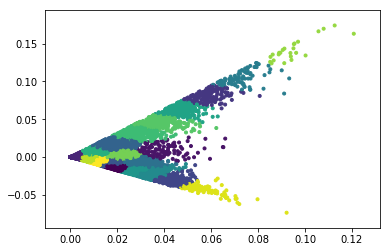

Homogeneity Score:  0.257968119094
Completeness Score:  0.304272227624
V-measure Score:  0.279213452791
Adjusted Rand Score:  0.0747881448818
Adjusted Mutual Info Score:  0.255562965664

Normalize then log


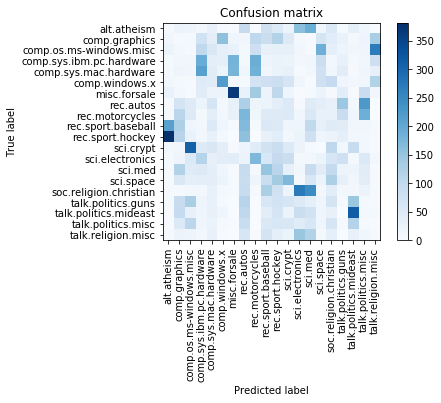

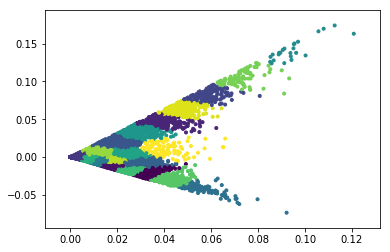

Homogeneity Score:  0.185776905577
Completeness Score:  0.187027976868
V-measure Score:  0.186400342029
Adjusted Rand Score:  0.075379677315
Adjusted Mutual Info Score:  0.183149470774

Log then normalize


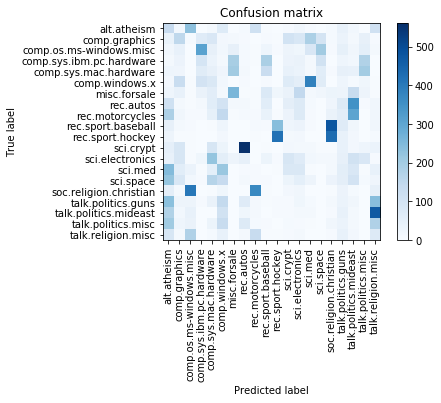

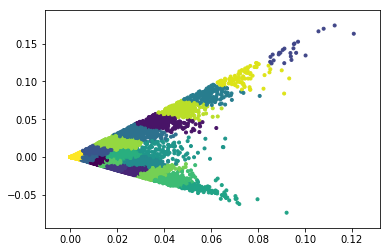

Homogeneity Score:  0.290156950755
Completeness Score:  0.294980870234
V-measure Score:  0.29254902612
Adjusted Rand Score:  0.14003656553
Adjusted Mutual Info Score:  0.287865859558

Min df:  3
Number of principle components:  30

No transformation


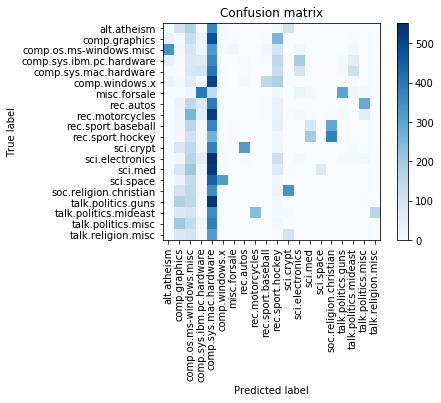

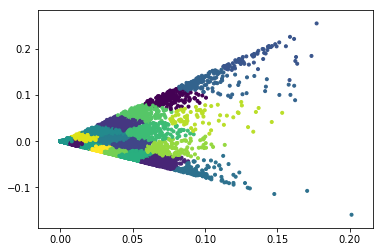

Homogeneity Score:  0.221541816135
Completeness Score:  0.308593356732
V-measure Score:  0.257920380298
Adjusted Rand Score:  0.0341941982248
Adjusted Mutual Info Score:  0.218987450124

Normalize then log


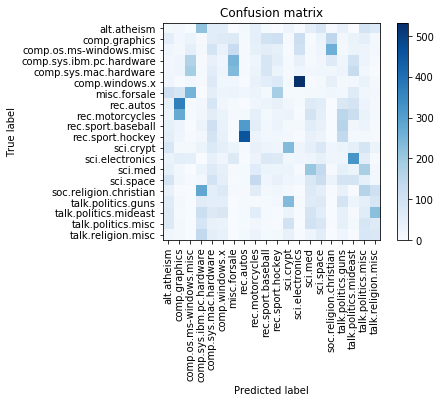

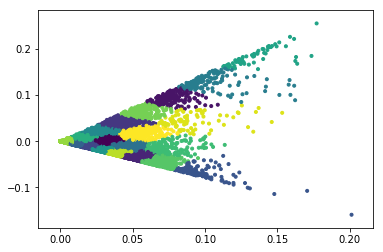

Homogeneity Score:  0.197555158743
Completeness Score:  0.198241897793
V-measure Score:  0.197897932495
Adjusted Rand Score:  0.0921914797907
Adjusted Mutual Info Score:  0.194965922782

Log then normalize


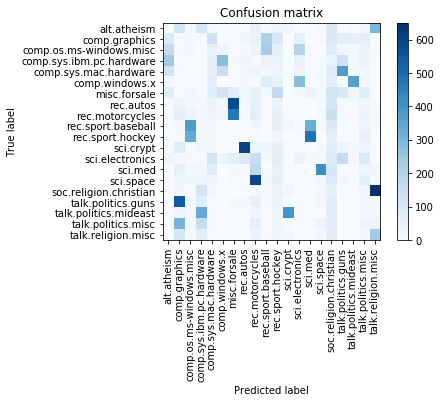

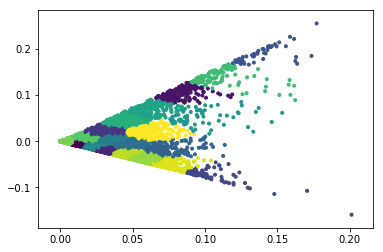

Homogeneity Score:  0.343779522028
Completeness Score:  0.349534180178
V-measure Score:  0.346632968631
Adjusted Rand Score:  0.200114801737
Adjusted Mutual Info Score:  0.341661403057

Min df:  3
Number of principle components:  100

No transformation


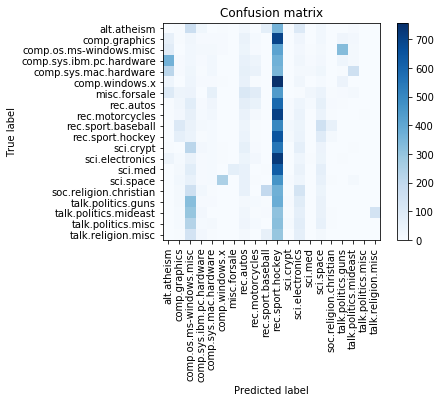

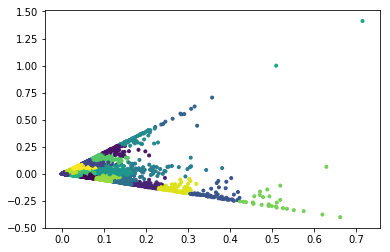

Homogeneity Score:  0.120146742565
Completeness Score:  0.192096586324
V-measure Score:  0.147832007728
Adjusted Rand Score:  0.0183998414611
Adjusted Mutual Info Score:  0.11725419066

Normalize then log


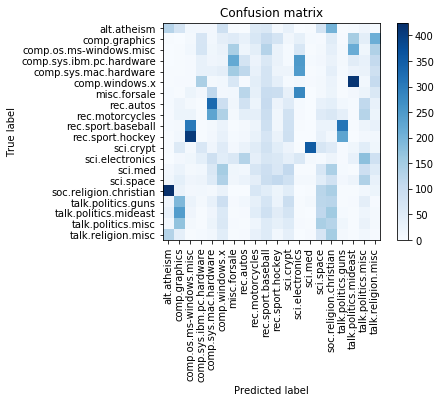

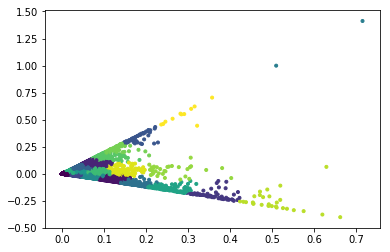

Homogeneity Score:  0.213937080224
Completeness Score:  0.216601002759
V-measure Score:  0.21526080008
Adjusted Rand Score:  0.0926953219791
Adjusted Mutual Info Score:  0.211400002539

Log then normalize


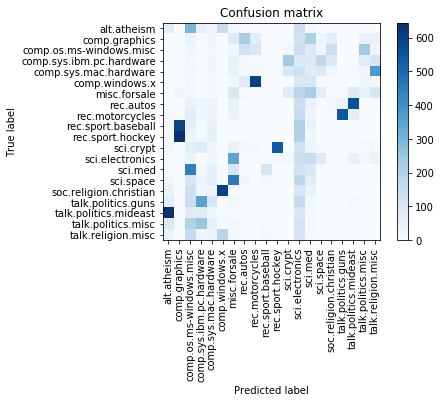

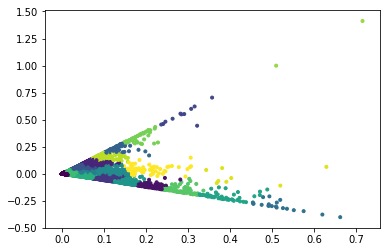

Homogeneity Score:  0.353101992152
Completeness Score:  0.374181577195
V-measure Score:  0.363336299355
Adjusted Rand Score:  0.185308868282
Adjusted Mutual Info Score:  0.351011206724


In [219]:
plot_metrics_nmf_20(rvals2)